#BIG DATA PROJECT - FAKE NEWS DETECTION USING PYSPARK

#Load the Datasets

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import lit


In [5]:
spark = SparkSession.builder.appName("FakeNewsDetection").getOrCreate()

In [6]:
true_data = spark.read.csv("/content/True.csv", header=True, inferSchema=True)
fake_data = spark.read.csv("/content/Fake.csv", header=True, inferSchema=True)

In [7]:
true_data = true_data.withColumn("Label", lit(1))
fake_data = fake_data.withColumn("Label", lit(0))

**Step 2: Combine Datasets**

In [8]:
# Combine datasets
data = true_data.union(fake_data)

#Data Preprocessing

In [9]:
# Drop rows with missing Text or Title
data = data.filter(data["text"].isNotNull() & data["title"].isNotNull())


In [10]:
from pyspark.sql.functions import regexp_replace, lower, col

# Clean text and title
data = data.withColumn("cleaned_text", regexp_replace(lower(col("text")), "[^a-zA-Z\s]", ""))
data = data.withColumn("cleaned_title", regexp_replace(lower(col("title")), "[^a-zA-Z\s]", ""))


In [11]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
data = tokenizer.transform(data)

In [12]:
from pyspark.ml.feature import HashingTF, IDF

#Tf=how many times each word appears
#IDF: The Inverse Document Frequency (IDF) class is used to calculate the
#inverse document frequency of words. It gives more importance to words that
#are less frequent across all documents, which helps reduce the impact of common
#words like "the" or "and" that appear in many documents.

# HashingTF and IDF
hashing_tf = HashingTF(inputCol="tokens", outputCol="raw_features", numFeatures=5000)
idf = IDF(inputCol="raw_features", outputCol="features")

# Transform data
data = hashing_tf.transform(data)
idf_model = idf.fit(data)
data = idf_model.transform(data)


In [13]:
from pyspark.sql.functions import length, size, split
from textblob import TextBlob

# Word and character count
#number of words in each document
data = data.withColumn("word_count", size(split(col("cleaned_text"), " ")))
data = data.withColumn("char_count", length(col("cleaned_text")))

# Sentiment analysis for title
def sentiment_score(title):
    return float(TextBlob(title).sentiment.polarity)

#registering the sentiment_score function as a User Defined Function (UDF) in PySpark, so it can be used in Spark SQL expressions
sentiment_udf = spark.udf.register("sentiment_udf", sentiment_score)
data = data.withColumn("title_sentiment", sentiment_udf(col("cleaned_title")))

data.select("word_count", "char_count", "title_sentiment").show()

+----------+----------+-------------------+
|word_count|char_count|    title_sentiment|
+----------+----------+-------------------+
|       753|      4474|                0.0|
|       625|      3960|               -0.1|
|       466|      2716|                0.0|
|       377|      2388|                0.0|
|       864|      4988|               0.35|
|       601|      3599|                0.0|
|       539|      3124|                0.7|
|       136|       782|                0.0|
|       101|       580|                0.0|
|        68|       394|                0.0|
|       402|      2294|                0.0|
|       632|      3689|0.13636363636363635|
|       100|       557|                0.7|
|       180|       956|                0.0|
|       371|      2036|0.13636363636363635|
|       447|      2654|                0.0|
|       691|      4179|                0.0|
|       178|      1032|                0.0|
|       391|      2438|                0.0|
|       211|      1228|         

#Exploratory Data Analysis

In [14]:
data.groupBy("Label").count().show()


+-----+-----+
|Label|count|
+-----+-----+
|    1| 3703|
|    0| 5789|
+-----+-----+



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


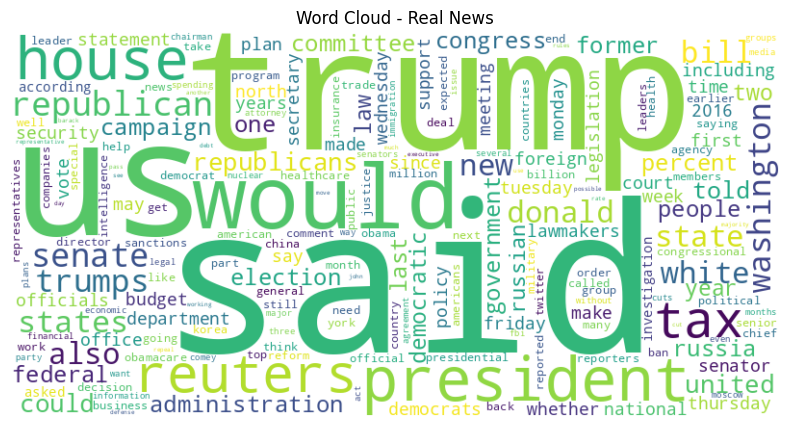

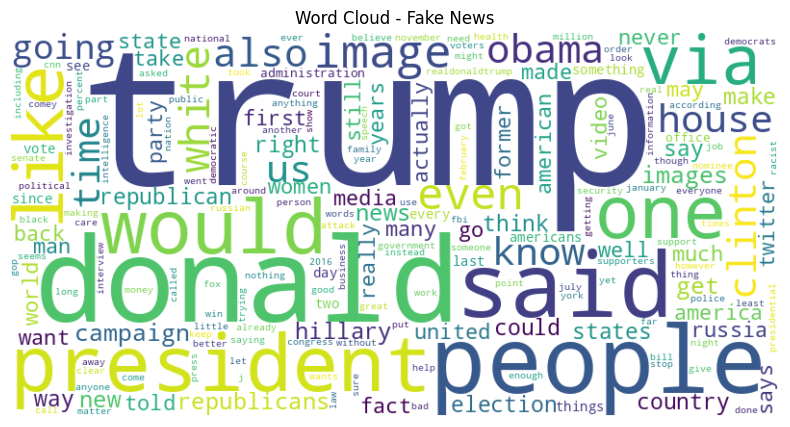

In [15]:
!pip install nltk
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
from pyspark.sql.functions import col, udf, explode
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords

nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
def clean_and_tokenize(text):
    if text:
        text = re.sub(r'[^\w\s]', '', text.lower())   # Remove punctuation and convert to lowercase
        return [word for word in text.split() if word not in stop_words]  # Tokenize and remove stopwords
    return []

clean_and_tokenize_udf = udf(clean_and_tokenize, ArrayType(StringType()))

data = data.withColumn("cleaned_text", clean_and_tokenize_udf(col("text")))

real_news = data.filter(col("Label") == 1).select(explode(col("cleaned_text")).alias("word"))
fake_news = data.filter(col("Label") == 0).select(explode(col("cleaned_text")).alias("word"))

def plot_wordcloud(words, title):
    word_counts = words.groupBy("word").count().toPandas()
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(
        word_counts.set_index("word")["count"].to_dict()
    )
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

plot_wordcloud(real_news, "Word Cloud - Real News")
plot_wordcloud(fake_news, "Word Cloud - Fake News")

#Model Training

In [16]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)


In [17]:
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier

In [18]:
# Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="Label")
lr_model = lr.fit(train_data)

In [19]:
# Naive Bayes
nb = NaiveBayes(featuresCol="features", labelCol="Label")
nb_model = nb.fit(train_data)

In [20]:
# Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="Label", numTrees=100)
rf_model = rf.fit(train_data)

In [24]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Initialize Naive Bayes model
nb = NaiveBayes(featuresCol="features", labelCol="Label", predictionCol="prediction")

# Define parameter grid
param_grid_nb = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.01, 0.1, 1.0, 10.0]) \
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(labelCol="Label", metricName="areaUnderROC")

# Initialize cross-validator
cv_nb = CrossValidator(estimator=nb, estimatorParamMaps=param_grid_nb, evaluator=evaluator, numFolds=5)

# Fit cross-validator
cv_nb_model = cv_nb.fit(train_data)

# Get best model
best_nb_model = cv_nb_model.bestModel

# Evaluate on test data
nb_predictions = best_nb_model.transform(test_data)
nb_auc = evaluator.evaluate(nb_predictions)
print(f"Best Naive Bayes Model AUC: {nb_auc}")


Best Naive Bayes Model AUC: 0.6076176286887437


In [26]:
from pyspark.ml.classification import RandomForestClassifier

# Initialize Random Forest model
rf = RandomForestClassifier(featuresCol="features", labelCol="Label", predictionCol="prediction")

# Define parameter grid
param_grid_rf = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 50, 100]) \
    .addGrid(rf.maxDepth, [5, 10, 20]) \
    .build()

# Initialize cross-validator
cv_rf = CrossValidator(estimator=rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)

# Fit cross-validator
cv_rf_model = cv_rf.fit(train_data)

# Get best model
best_rf_model = cv_rf_model.bestModel

# Evaluate on test data
rf_predictions = best_rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Best Random Forest Model AUC: {rf_auc}")


Best Random Forest Model AUC: 1.0


In [37]:
# Convert Spark DataFrame to Pandas DataFrame for sklearn processing
train_data_pd = train_data.toPandas()
test_data_pd = test_data.toPandas()

# Extract features and labels
X_train = np.array(train_data_pd["features"].tolist())
y_train = train_data_pd["Label"]

X_test = np.array(test_data_pd["features"].tolist())
y_test = test_data_pd["Label"]

# Logistic Regression
#lr = LogisticRegression()
#lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)

# Naive Bayes
#nb = MultinomialNB()
#nb.fit(X_train, y_train)
nb_predictions = nb.predict(X_test)

# Random Forest
#rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
#rf.fit(X_train, y_train)
rf_predictions = rf.predict(X_test)

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {
        "RMSE": rmse,
        "MSE": mse,
        "MAE": mae,
        "R2": r2,
        "MAPE": mape,
        "Accuracy": accuracy_score(y_true, y_pred),
    }

# Metrics for Logistic Regression
log_reg_metrics = calculate_metrics(y_test, lr_predictions)
print("Logistic Regression Metrics:", log_reg_metrics)

# Metrics for Naive Bayes
naive_bayes_metrics = calculate_metrics(y_test, nb_predictions)
print("Naive Bayes Metrics:", naive_bayes_metrics)

# Metrics for Random Forest
random_forest_metrics = calculate_metrics(y_test, rf_predictions)
print("Random Forest Metrics:", random_forest_metrics)


Logistic Regression Metrics: {'RMSE': 0.08741808392649608, 'MSE': 0.007641921397379912, 'MAE': 0.007641921397379912, 'R2': 0.9675064960402976, 'MAPE': inf, 'Accuracy': 0.99235807860262}
Naive Bayes Metrics: {'RMSE': 0.19123820852995546, 'MSE': 0.03657205240174673, 'MAE': 0.03657205240174673, 'R2': 0.8444953739071386, 'MAPE': inf, 'Accuracy': 0.9634279475982532}
Random Forest Metrics: {'RMSE': 0.0738817655706927, 'MSE': 0.0054585152838427945, 'MAE': 0.0054585152838427945, 'R2': 0.9767903543144983, 'MAPE': inf, 'Accuracy': 0.9945414847161572}


#Evaluation

In [38]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Label", metricName="accuracy")
lr_accuracy = evaluator.evaluate(lr_model.transform(test_data))
nb_accuracy = evaluator.evaluate(nb_model.transform(test_data))
rf_accuracy = evaluator.evaluate(rf_model.transform(test_data))

print(f"Logistic Regression Accuracy: {lr_accuracy}")
print(f"Naive Bayes Accuracy: {nb_accuracy}")
print(f"Random Forest Accuracy: {rf_accuracy}")


Logistic Regression Accuracy: 0.9830786026200873
Naive Bayes Accuracy: 0.9634279475982532
Random Forest Accuracy: 0.9950873362445415


In [39]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

f1_evaluator = MulticlassClassificationEvaluator(labelCol="Label", metricName="f1")
weighted_precision_evaluator = MulticlassClassificationEvaluator(labelCol="Label", metricName="weightedPrecision")
weighted_recall_evaluator = MulticlassClassificationEvaluator(labelCol="Label", metricName="weightedRecall")

lr_f1 = f1_evaluator.evaluate(lr_model.transform(test_data))
nb_f1 = f1_evaluator.evaluate(nb_model.transform(test_data))
rf_f1 = f1_evaluator.evaluate(rf_model.transform(test_data))

lr_weighted_precision = weighted_precision_evaluator.evaluate(lr_model.transform(test_data))
nb_weighted_precision = weighted_precision_evaluator.evaluate(nb_model.transform(test_data))
rf_weighted_precision = weighted_precision_evaluator.evaluate(rf_model.transform(test_data))

lr_weighted_recall = weighted_recall_evaluator.evaluate(lr_model.transform(test_data))
nb_weighted_recall = weighted_recall_evaluator.evaluate(nb_model.transform(test_data))
rf_weighted_recall = weighted_recall_evaluator.evaluate(rf_model.transform(test_data))


print(f"Logistic Regression F1 Score: {lr_f1}")
print(f"Naive Bayes F1 Score: {nb_f1}")
print(f"Random Forest F1 Score: {rf_f1}")

print(f"Logistic Regression Weighted Precision: {lr_weighted_precision}")
print(f"Naive Bayes Weighted Precision: {nb_weighted_precision}")
print(f"Random Forest Weighted Precision: {rf_weighted_precision}")

print(f"Logistic Regression Weighted Recall: {lr_weighted_recall}")
print(f"Naive Bayes Weighted Recall: {nb_weighted_recall}")
print(f"Random Forest Weighted Recall: {rf_weighted_recall}")


Logistic Regression F1 Score: 0.9831261600955796
Naive Bayes F1 Score: 0.963401790094909
Random Forest F1 Score: 0.9950907623369154
Logistic Regression Weighted Precision: 0.9834447533690809
Naive Bayes Weighted Precision: 0.9633908580565875
Random Forest Weighted Precision: 0.9951098935176441
Logistic Regression Weighted Recall: 0.9830786026200873
Naive Bayes Weighted Recall: 0.9634279475982532
Random Forest Weighted Recall: 0.9950873362445416


In [40]:
rf_model.featureImportances

SparseVector(5000, {15: 0.0, 19: 0.0, 20: 0.0003, 29: 0.0, 35: 0.0, 38: 0.0004, 52: 0.0, 56: 0.0045, 58: 0.0, 63: 0.0, 66: 0.0004, 68: 0.002, 73: 0.0029, 74: 0.0, 76: 0.0011, 78: 0.0, 84: 0.0, 91: 0.0, 92: 0.0, 94: 0.0012, 114: 0.0001, 119: 0.0, 122: 0.0022, 125: 0.0004, 132: 0.0006, 133: 0.0001, 139: 0.0005, 141: 0.004, 145: 0.0001, 146: 0.0001, 150: 0.0002, 154: 0.0, 173: 0.0, 183: 0.0003, 185: 0.0009, 188: 0.0, 193: 0.0001, 195: 0.0, 196: 0.0002, 200: 0.0, 201: 0.0001, 204: 0.0, 207: 0.0, 209: 0.011, 215: 0.0, 216: 0.0008, 217: 0.0, 224: 0.0, 228: 0.0, 238: 0.0, 250: 0.0001, 251: 0.0008, 253: 0.0, 258: 0.0004, 260: 0.0, 268: 0.0, 273: 0.0, 279: 0.0, 281: 0.0012, 296: 0.0, 303: 0.0676, 307: 0.0183, 308: 0.0, 312: 0.0001, 314: 0.0022, 315: 0.0, 316: 0.0, 317: 0.0, 320: 0.0003, 321: 0.0, 328: 0.0004, 344: 0.0, 347: 0.0, 354: 0.0, 363: 0.0001, 366: 0.0071, 367: 0.0, 372: 0.0, 373: 0.0077, 376: 0.0003, 386: 0.0002, 392: 0.0, 396: 0.0001, 402: 0.0, 403: 0.0, 410: 0.0, 416: 0.0, 418: 0.001

In [41]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate accuracy
accuracy = evaluator.evaluate(rf_model.transform(test_data))
print(f"Accuracy: {accuracy}")

# Binary metrics
binary_evaluator = BinaryClassificationEvaluator(labelCol="Label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = binary_evaluator.evaluate(rf_model.transform(test_data))
print(f"ROC-AUC: {roc_auc}")


Accuracy: 0.9950873362445415
ROC-AUC: 0.9994957729812866


In [42]:
from pyspark.sql.functions import col

# Get predictions
predictions = rf_model.transform(test_data)

# Confusion matrix counts
tp = predictions.filter((col('Label') == 1) & (col('prediction') == 1)).count()
fp = predictions.filter((col('Label') == 0) & (col('prediction') == 1)).count()
tn = predictions.filter((col('Label') == 0) & (col('prediction') == 0)).count()
fn = predictions.filter((col('Label') == 1) & (col('prediction') == 0)).count()

print(f"Confusion Matrix: TP={tp}, FP={fp}, TN={tn}, FN={fn}")


Confusion Matrix: TP=691, FP=7, TN=1132, FN=2


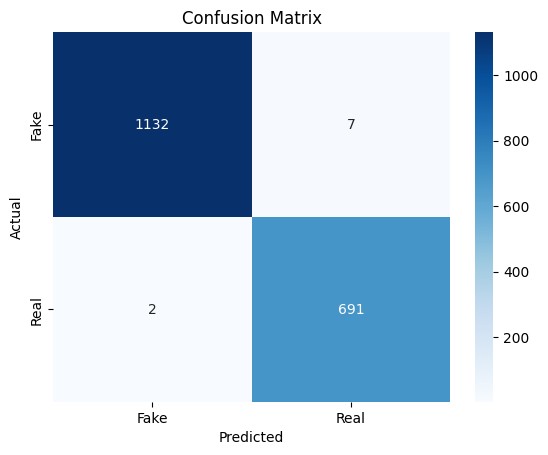

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix data
conf_matrix = [[tn, fp], [fn, tp]]

# Plot
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


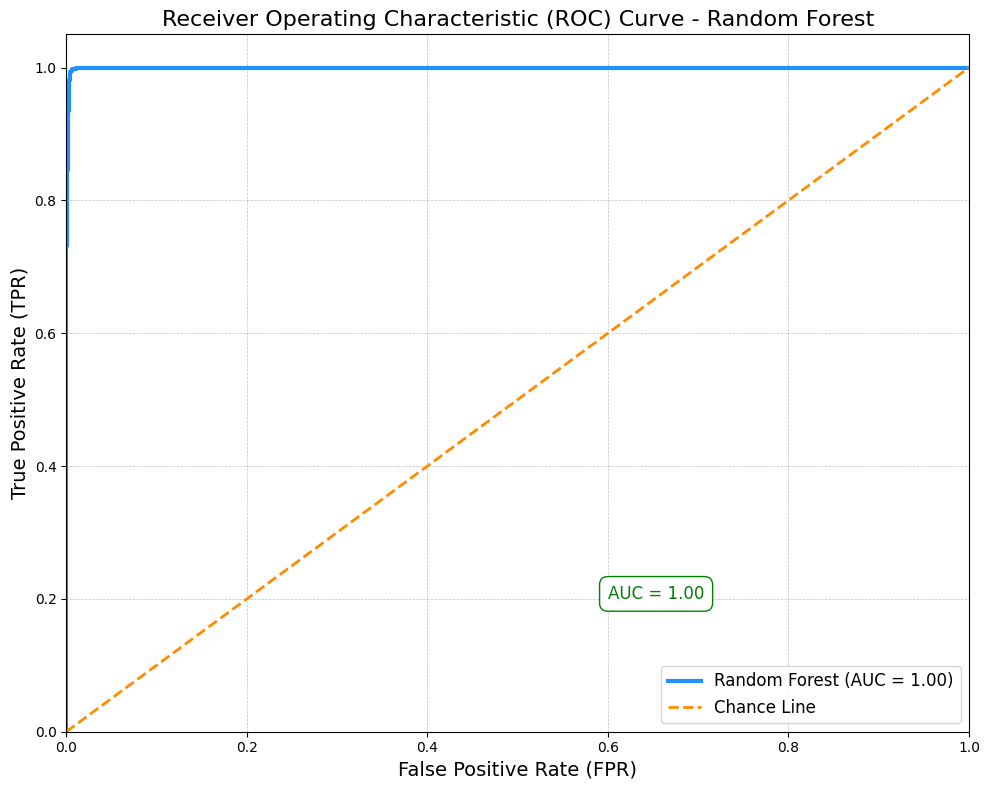

In [49]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probabilities and true labels
predictions = rf_model.transform(test_data)
y_true = np.array(predictions.select('Label').collect()).flatten()
# Extract the probability of the positive class (index 1) from the DenseVector
y_scores = np.array(predictions.select('probability').rdd.map(lambda x: float(x[0][1])).collect())

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)


# Plot ROC curve with enhancements
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='dodgerblue', lw=3, label=f'Random Forest (AUC = {roc_auc:.2f})')  #line style and color
plt.plot([0, 1], [0, 1], color='darkorange', linestyle='--', lw=2, label='Chance Line')  # Diagonal line

# Add grid with customized style
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Set the axis limits for better clarity
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

# Labeling and styling
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest', fontsize=16)

# Add a legend
plt.legend(loc='lower right', fontsize=12)

# Add AUC value to the plot (optional)
plt.text(0.6, 0.2, f'AUC = {roc_auc:.2f}', fontsize=12, color='green', bbox=dict(facecolor='white', edgecolor='green', boxstyle='round,pad=0.5'))

# Tweak layout and show the plot
plt.tight_layout()
plt.show()
